In [1]:
from matplotlib import pyplot as plt
import numpy as np

from metrics.mot_ground_truth_assigner import MOTGroundTruthAssigner
from models.ocsort_utils.metric_utils import iou_batch


print(plt.rcParams["figure.figsize"])

[6.4, 4.8]


In [2]:
class PrecomputedMOTTracker():

    def __init__(self, seq_path=None):
        self.seq_dets = np.loadtxt(seq_path, delimiter=',')
        
        self.last_frame = int(self.seq_dets[:, 0].max())
    
    def __call__(self, frame):
        tracks = self.seq_dets[self.seq_dets[:, 0] == frame, :]
        return tracks

In [3]:
def center(tracks):
    cx = tracks[..., 0] + (tracks[..., 2] / 2.0)
    cy = tracks[..., 1] + (tracks[..., 3] / 2.0)

    return cx, cy

def speed(tracks1, tracks2):

    cx1, cy1 = center(tracks1)
    cx2, cy2 = center(tracks2)

    dx = cx2 - cx1
    dy = cy2 - cy1

    return dx, dy

def compute_iou(tracks1, tracks2):
    xx1 = np.maximum(tracks1[..., 0], tracks2[..., 0])
    yy1 = np.maximum(tracks1[..., 1], tracks2[..., 1])
    xx2 = np.minimum(tracks1[..., 0] + tracks1[..., 2], tracks2[..., 0] + tracks2[..., 2])
    yy2 = np.minimum(tracks1[..., 1] + tracks1[..., 3], tracks2[..., 1] + tracks2[..., 3])

    w = np.maximum(0., xx2 - xx1)
    h = np.maximum(0., yy2 - yy1)

    intersection_area_matrix = w * h

    area_test = tracks1[..., 2] * tracks1[..., 3]
    area_gt = tracks2[..., 2] * tracks2[..., 3]

    union_area_matrix = (area_test + area_gt - intersection_area_matrix)

    iou = intersection_area_matrix / union_area_matrix

    return iou

def compute_ciou(tracks1, tracks2):
    distance = lambda cx1, cy1, cx2, cy2 : (cx1 - cx2) ** 2 + (cy1 - cy2) ** 2

    max_ar_dist = np.pi ** 2. / 4.0 # Normalization term
    ar_distance = lambda w1, h1, w2, h2 : ((np.arctan(w2 / (h2 + 1)) - np.arctan(w1 / (h1 + 1))) ** 2) / max_ar_dist # cuadratic angular distance

    iou = compute_iou(tracks1, tracks2)

    cx1, cy1 = center(tracks1)
    cx2, cy2 = center(tracks2)

    inner_diag = distance(cx1, cy1, cx2, cy2)

    xx1 = np.minimum(tracks1[..., 0], tracks2[..., 0])
    yy1 = np.minimum(tracks1[..., 1], tracks2[..., 1])
    xx2 = np.maximum(tracks1[..., 0] + tracks1[..., 2], tracks2[..., 0] + tracks2[..., 2])
    yy2 = np.maximum(tracks1[..., 1] + tracks1[..., 3], tracks2[..., 1] + tracks2[..., 3])

    outer_diag = distance(xx1, yy1, xx2, yy2)

    ioo_dist = inner_diag / outer_diag
    ar_dist = ar_distance(tracks1[..., 2], tracks1[..., 3], tracks2[..., 2], tracks2[..., 3])

    S = 1 - iou
    S[S == 0] = np.finfo(S.dtype).eps
    ar_cost = ar_dist / (ar_dist + S)

    ciou_matrix = iou - ioo_dist - ar_cost * ar_dist
    ciou_matrix = (ciou_matrix + 1.) / 2.0
    return ciou_matrix



In [4]:

gt_tracker = PrecomputedMOTTracker('./DATA/output_4_gt.txt')
#tracker = PrecomputedMOTTracker('./OUTPUT/ocsort_tracking_output_4_kalman.txt')
#tracker = PrecomputedMOTTracker('./OUTPUT/output_4_track_with_dets_pca.txt')
tracker = PrecomputedMOTTracker('./OUTPUT/output_4_pca.txt')

In [5]:
def concat_speed_and_iou_and_ciou(tracker: PrecomputedMOTTracker):
    tck_id_sort = np.argsort(tracker.seq_dets[:, 1], kind="stable")

    first_mask = ~(tracker.seq_dets[tck_id_sort[:-1], 1] == tracker.seq_dets[tck_id_sort[1:], 1])
    discontinuity_mask = ~((tracker.seq_dets[tck_id_sort[:-1], 0] + 1) == tracker.seq_dets[tck_id_sort[1:], 0])

    dx, dy = speed(tracker.seq_dets[tck_id_sort[:-1], 2:6], tracker.seq_dets[tck_id_sort[1:], 2:6])
    iou = compute_iou(tracker.seq_dets[tck_id_sort[1:], 2:6], tracker.seq_dets[tck_id_sort[:-1], 2:6])
    ciou = compute_ciou(tracker.seq_dets[tck_id_sort[1:], 2:6], tracker.seq_dets[tck_id_sort[:-1], 2:6])
    
    # NOTE: Discontinuity mask could be used for dividing by the number of frames between detections

    dx[first_mask & discontinuity_mask] = np.nan
    dy[first_mask & discontinuity_mask] = np.nan
    iou[first_mask & discontinuity_mask] = np.nan
    ciou[first_mask & discontinuity_mask] = np.nan

    sorted_seqs = np.hstack(
        (tracker.seq_dets[tck_id_sort].reshape(-1, 10),
         np.concatenate(([np.nan], dx)).reshape(-1, 1),
         np.concatenate(([np.nan], dy)).reshape(-1, 1),
         np.concatenate(([np.nan], iou)).reshape(-1, 1),
         np.concatenate(([np.nan], ciou)).reshape(-1, 1))
    )
    tracker.seq_dets = np.empty(sorted_seqs.shape)
    tracker.seq_dets[tck_id_sort] = sorted_seqs

    return tracker

Ground Truth speed
	Mean: 17.77 px/frame
	Variance: 151.67

from 100 to 425.15 there are 15 elements


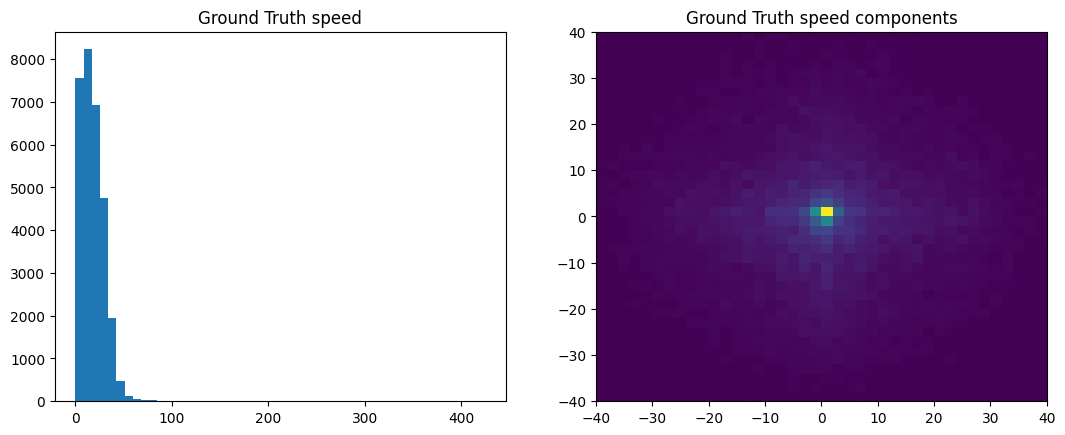

In [6]:
# Speed of gt_tracks, histogram, mean and variance
if gt_tracker.seq_dets.shape[-1] == 10:
    concat_speed_and_iou_and_ciou(gt_tracker)

gt_valid_mask = np.isfinite(gt_tracker.seq_dets[:, 13]) # [:, 12] or [:, 13]
gt_speed_mod = np.linalg.norm(gt_tracker.seq_dets[gt_valid_mask, 10:12], axis=1)

gt_speed_mean = np.mean(gt_speed_mod)
gt_speed_var = np.var(gt_speed_mod)

plt.figure(figsize=(6.4 * 2, 4.8))
plt.subplot(1, 2, 1)
plt.hist(gt_speed_mod, bins=50)
plt.title('Ground Truth speed')

plt.subplot(1, 2, 2)
plt.hist2d(gt_tracker.seq_dets[gt_valid_mask, 10], gt_tracker.seq_dets[gt_valid_mask, 11], bins=40, range=[[-40, 40], [-40, 40]])
plt.title('Ground Truth speed components')

print(f'Ground Truth speed\n\tMean: {gt_speed_mean:,.02f} px/frame\n\tVariance: {gt_speed_var:,.02f}', end='\n\n')
print(f'from 100 to {max(gt_speed_mod):.02f} there are {sum(gt_speed_mod > 100)} elements')


Tracker speed
	Mean: 18.92 px/frame
	Variance: 282.02
from 100 to 629.02 there are 100 elements


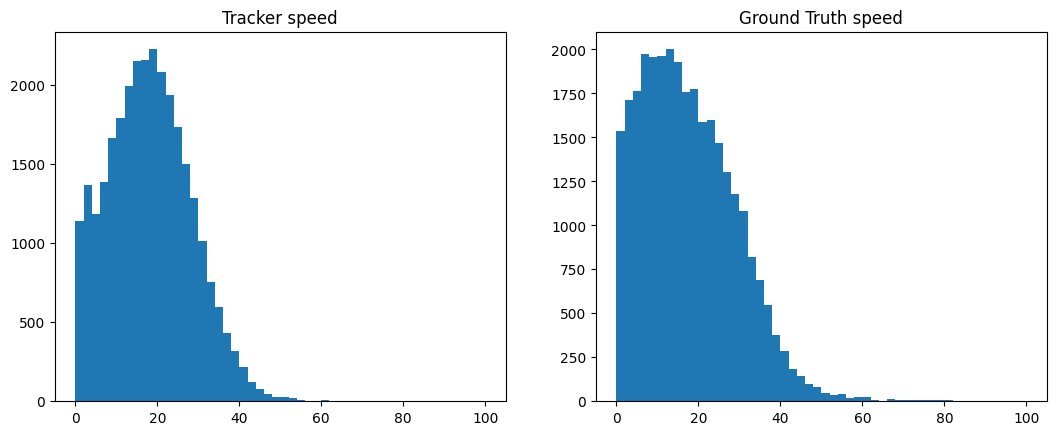

In [7]:
# Speed of tracks, histogram, mean and variance
if tracker.seq_dets.shape[-1] == 10:
    tracker.seq_dets = tracker.seq_dets[tracker.seq_dets[:, 0] <= gt_tracker.seq_dets[:, 0].max(), :]
    concat_speed_and_iou_and_ciou(tracker)

tck_valid_mask = np.isfinite(tracker.seq_dets[:, 12])
tck_speed_mod = np.linalg.norm(tracker.seq_dets[tck_valid_mask, 10:12], axis=1)

tck_speed_mean = np.mean(tck_speed_mod)
tck_speed_var = np.var(tck_speed_mod)

plt.figure(figsize=(6.4 * 2, 4.8))
plt.subplot(1, 2, 1)
plt.hist(tck_speed_mod, bins=50, range=(0, 100))
plt.title('Tracker speed')

plt.subplot(1, 2, 2)
plt.hist(gt_speed_mod, bins=50, range=(0, 100))
plt.title('Ground Truth speed')

print(f'Tracker speed\n\tMean: {tck_speed_mean:,.02f} px/frame\n\tVariance: {tck_speed_var:,.02f}')
print(f'from 100 to {max(tck_speed_mod):.02f} there are {sum(tck_speed_mod > 100)} elements')

Text(0.5, 1.0, 'Ground Truth IoU t-1 to t')

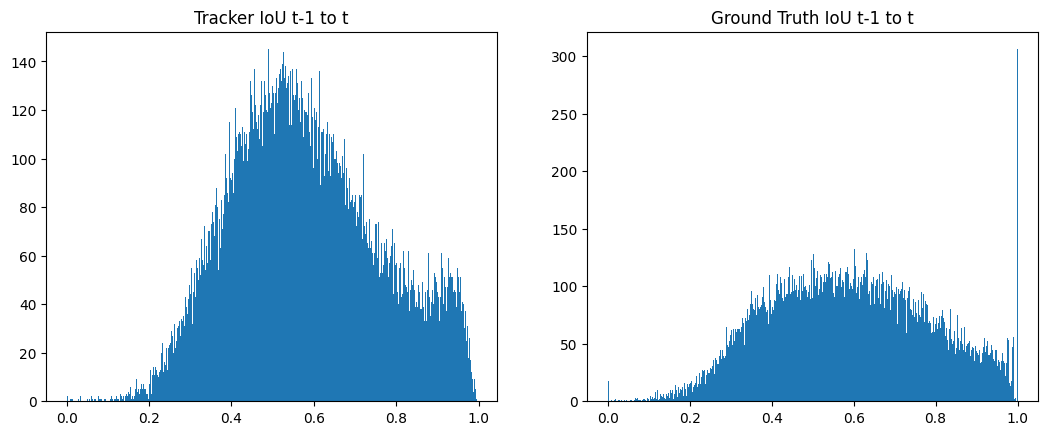

In [8]:
plt.figure(figsize=(6.4 * 2, 4.8))
plt.subplot(1, 2, 1)
plt.hist(tracker.seq_dets[tck_valid_mask, 12], bins=500)
plt.title('Tracker IoU t-1 to t')

plt.subplot(1, 2, 2)
plt.hist(gt_tracker.seq_dets[gt_valid_mask, 12], bins=500)
plt.title('Ground Truth IoU t-1 to t')


Text(0.5, 1.0, 'Ground Truth cIoU t-1 to t')

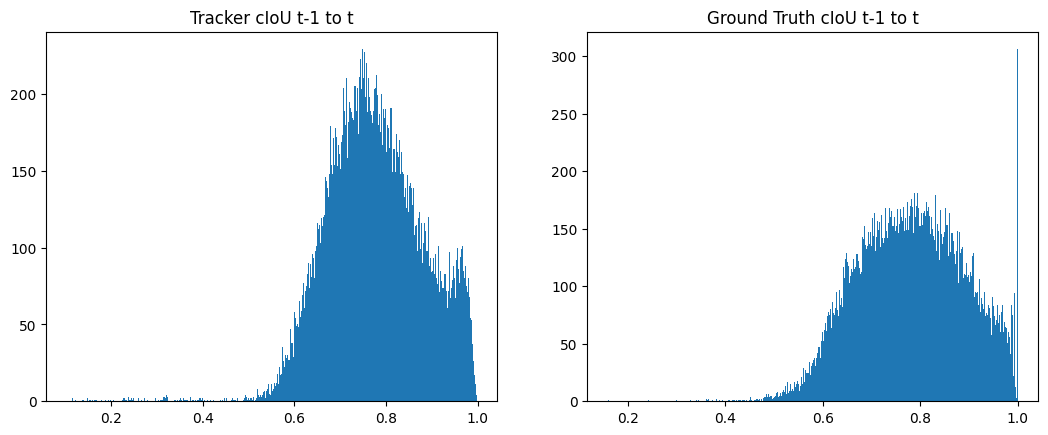

In [9]:
plt.figure(figsize=(6.4 * 2, 4.8))
plt.subplot(1, 2, 1)
plt.hist(tracker.seq_dets[tck_valid_mask, 13], bins=500)
plt.title('Tracker cIoU t-1 to t')

plt.subplot(1, 2, 2)
plt.hist(gt_tracker.seq_dets[gt_valid_mask, 13], bins=500)
plt.title('Ground Truth cIoU t-1 to t')


In [16]:

iou_batch_dist = lambda bb_test, bb_gt : 1 - iou_batch(bb_test, bb_gt)
tracks_assigner = MOTGroundTruthAssigner(iou_batch_dist, 0.5)

gt_tck_angle_diff = []
gt_tck_angle_err = []
gt_tck_mod_diff = []
gt_tck_iou = []
gt_pca_angle_diff = []
gt_pca_angle_err = []
gt_pca_iou = []

previous_assigments = np.empty((0, 2), dtype=int)
lost_gt_tracks = dict() # To keep info about gt that has an ID but now are free

id_sw = 0
frag = 0
tp = 0
fp = 0
fn = 0

for frame in range(1, gt_tracker.last_frame + 1):

    gt_tracks = gt_tracker(frame)
    tracks = tracker(frame)
    prev_tracks = tracker(frame - 1)

    assigments = tracks_assigner(gt_tracks, tracks) # IDs gt, IDs tck

    tp += len(assigments)
    fp += len(tracks) - len(assigments)
    fn += len(gt_tracks) - len(assigments)

    # Speed of tracks and gt_tracks
    for gt, tck in assigments:

        gt_tck_iou.extend(compute_iou(gt_tracks[gt_tracks[:, 1] == gt, 2:6], tracks[tracks[:, 1] == tck, 2:6]))

        if tck in set(prev_tracks[:, 1]):
            origin_track = np.array(center(prev_tracks[prev_tracks[:, 1] == tck, 2:6]))
            gt_track = np.array(center(gt_tracks[gt_tracks[:, 1] == gt, 2:6]))
            pred_track = np.array(center(tracks[tracks[:, 1] == tck, 2:6]))
            
            o_gt = gt_track - origin_track
            m_o_gt = np.linalg.norm(o_gt) + np.finfo(o_gt.dtype).eps
            a_o_gt = np.arccos(o_gt[0, 0] / m_o_gt) * 180 / np.pi * (1. if o_gt[1, 0] >= 0 else -1.)
            
            o_tck = pred_track - origin_track
            m_o_tck = np.linalg.norm(o_tck) + np.finfo(o_tck.dtype).eps
            a_o_tck_rad = np.arccos(o_tck[0, 0] / m_o_tck) * (1. if o_tck[1, 0] >= 0 else -1.)
            a_o_tck = a_o_tck_rad * 180 / np.pi

            a_err_o_tck = np.arccos(np.dot(o_tck.T, o_gt)[0, 0] / (m_o_tck * m_o_gt)) * 180 / np.pi

            gt_tck_angle_diff.append(a_o_tck - a_o_gt if np.abs(a_o_tck - a_o_gt) <= 180 else a_o_tck - a_o_gt + 360 * (1. if a_o_gt > a_o_tck else -1.))
            gt_tck_mod_diff.append(m_o_tck - m_o_gt)
            gt_tck_angle_err.append(a_err_o_tck)

            if previous_assigments.size > 0 and previous_assigments[previous_assigments[:, 1] == tck, 0] == gt:
                origin_pca_angle = prev_tracks[prev_tracks[:, 1] == tck, 9]
                angle_dist = min(np.abs(a_o_tck_rad - origin_pca_angle), 2 * np.pi - np.abs(a_o_tck_rad - origin_pca_angle))
                origin_pca_angle = origin_pca_angle if (2 * angle_dist) < np.pi else np.pi + origin_pca_angle

                pca_track = tracks[tracks[:, 1] == tck, 2:6].copy()
                pca_track[0, 0] = prev_tracks[prev_tracks[:, 1] == tck, 2] + m_o_tck * np.cos(origin_pca_angle)
                pca_track[0, 1] = prev_tracks[prev_tracks[:, 1] == tck, 3] + m_o_tck * np.sin(origin_pca_angle)

                o_pca = np.array(center(pca_track)) - origin_track
                a_o_pca = np.arccos(o_pca[0, 0] / m_o_tck) * 180 / np.pi * (1. if o_pca[1, 0] >= 0 else -1.)
                a_err_o_pca = np.arccos(np.dot(o_pca.T, o_gt)[0, 0] / (m_o_tck * m_o_gt)) * 180 / np.pi

                gt_pca_angle_diff.append(a_o_pca - a_o_gt if np.abs(a_o_pca - a_o_gt) <= 180 else a_o_pca - a_o_gt + 360 * (1. if a_o_gt > a_o_pca else -1.))
                gt_pca_angle_err.append(a_err_o_pca)
                gt_pca_iou.append(compute_iou(gt_tracks[gt_tracks[:, 1] == gt, 2:6], pca_track)[0])

    # ID switch, Fragmentations, TP, FP, FN
    for gt, tck in previous_assigments:
        if gt in set(assigments[:, 0]):
            if tck != assigments[assigments[:, 0] == gt, 1]:
                id_sw += 1
        else:
            frag += 1
            lost_gt_tracks[gt] = tck
    
    for gt, tck in assigments:
        if gt in set(lost_gt_tracks.keys()):
            if lost_gt_tracks[gt] != tck:
                id_sw += 1
            del lost_gt_tracks[gt]

    previous_assigments = assigments

mota = 1 - (fn + fp + id_sw) / len(gt_tracker.seq_dets)
motp = float(np.sum(gt_tck_iou) / (tp + np.finfo(float).eps))

print(f'{id_sw=}\n{frag=}\n{tp=}\n{fp=}\n{fn=}\n{mota=:.02f}\n{motp=:.02f}')



/tmp/ipykernel_8439/1137997382.py:68: RuntimeWarning: invalid value encountered in arccos
  a_o_pca = np.arccos(o_pca[0, 0] / m_o_tck) * 180 / np.pi * (1. if o_pca[1, 0] >= 0 else -1.)
/tmp/ipykernel_8439/1137997382.py:69: RuntimeWarning: invalid value encountered in arccos
  a_err_o_pca = np.arccos(np.dot(o_pca.T, o_gt)[0, 0] / (m_o_tck * m_o_gt)) * 180 / np.pi
/tmp/ipykernel_8439/1137997382.py:58: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if len(previous_assigments) > 0 and previous_assigments[previous_assigments[:, 1] == tck, 0] == gt:


id_sw=81
frag=4202
tp=16624
fp=12973
fn=13769
mota=0.12
motp=0.65


Text(0.5, 1.0, 'angle error')

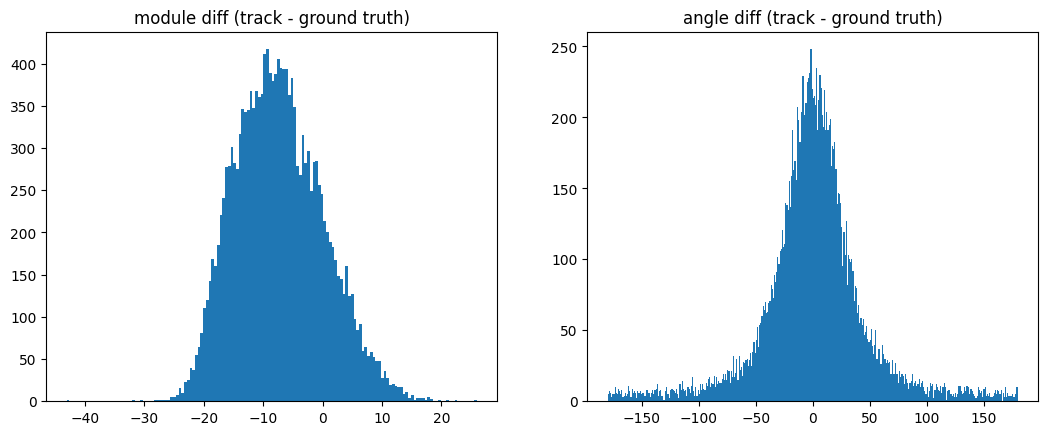

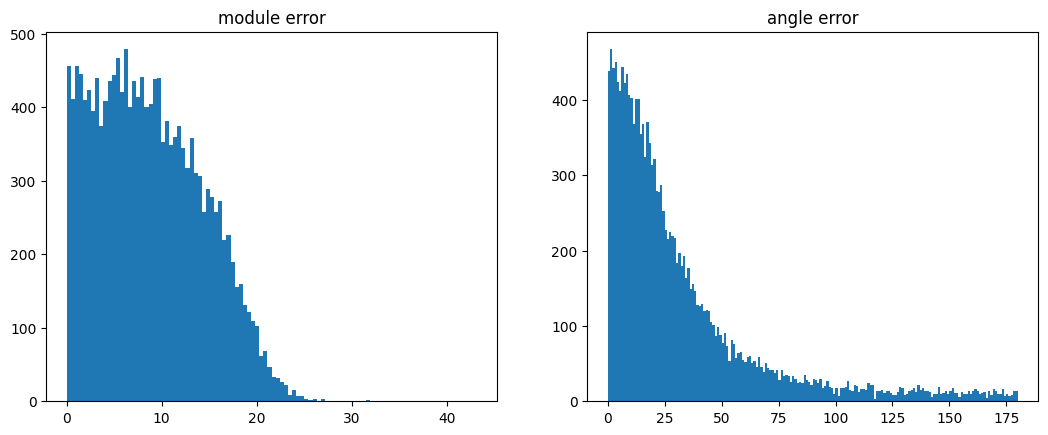

In [11]:
plt.figure(figsize=(6.4 * 2, 4.8))
plt.subplot(1, 2, 1)
plt.hist(gt_tck_mod_diff, bins=150)
plt.title('module diff (track - ground truth)')

plt.subplot(1, 2, 2)
plt.hist(gt_tck_angle_diff, bins=360)
plt.title('angle diff (track - ground truth)')

# Absolute values
plt.figure(figsize=(6.4 * 2, 4.8))
plt.subplot(1, 2, 1)
plt.hist(np.abs(np.asarray(gt_tck_mod_diff)), bins=100)
plt.title('module error')

#gt_tck_angle_err = np.abs(np.asarray(gt_tck_angle_diff))

plt.subplot(1, 2, 2)
plt.hist(gt_tck_angle_err, bins=180)
plt.title('angle error')


Text(0.5, 1.0, 'angle error (pca_track - ground truth)')

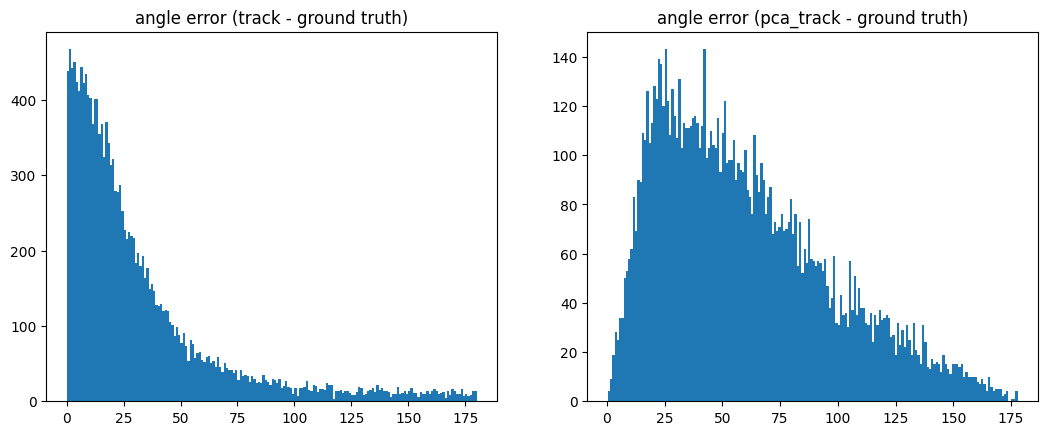

In [12]:
plt.figure(figsize=(6.4 * 2, 4.8))
plt.subplot(1, 2, 1)
plt.hist(gt_tck_angle_err, bins=180)
plt.title('angle error (track - ground truth)')

#gt_tck_angle_err = np.abs(np.asarray(gt_tck_angle_diff))

plt.subplot(1, 2, 2)
plt.hist(gt_pca_angle_err, bins=180)
plt.title('angle error (pca_track - ground truth)')

Text(0.5, 1.0, 'IoU (pca_track - ground truth)')

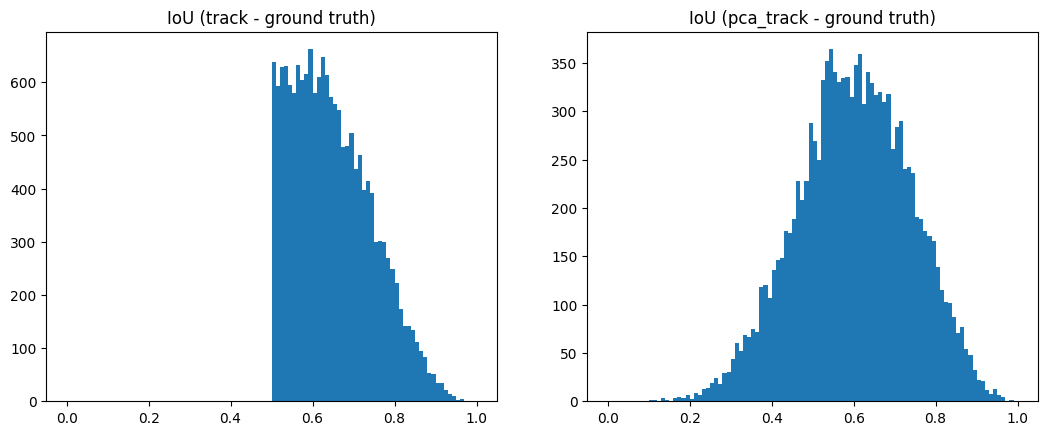

In [13]:
plt.figure(figsize=(6.4 * 2, 4.8))
plt.subplot(1, 2, 1)
plt.hist(gt_tck_iou, bins=100, range=[0, 1])
plt.title('IoU (track - ground truth)')

plt.subplot(1, 2, 2)
plt.hist(gt_pca_iou, bins=100, range=[0, 1])
plt.title('IoU (pca_track - ground truth)')


Text(0.5, 1.0, 'High IoU (pca_track - ground truth)')

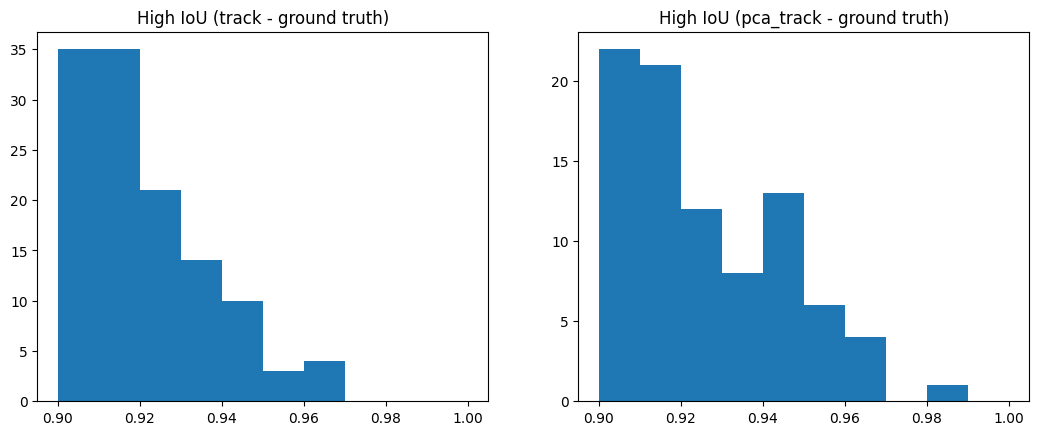

In [14]:
plt.figure(figsize=(6.4 * 2, 4.8))
plt.subplot(1, 2, 1)
plt.hist(gt_tck_iou, bins=10, range=[0.9, 1])
plt.title('High IoU (track - ground truth)')

plt.subplot(1, 2, 2)
plt.hist(gt_pca_iou, bins=10, range=[0.9, 1])
plt.title('High IoU (pca_track - ground truth)')

(-0.79, 2.35)

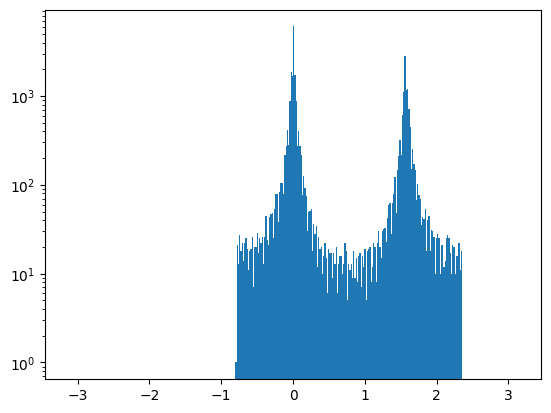

In [15]:
plt.figure()
plt.hist(tracker.seq_dets[:, 9], bins=360, range=[-np.pi, np.pi], log=True)

min(tracker.seq_dets[:, 9]), max(tracker.seq_dets[:, 9])